Real Estate: Exploratory Data Analysis





#Introduction

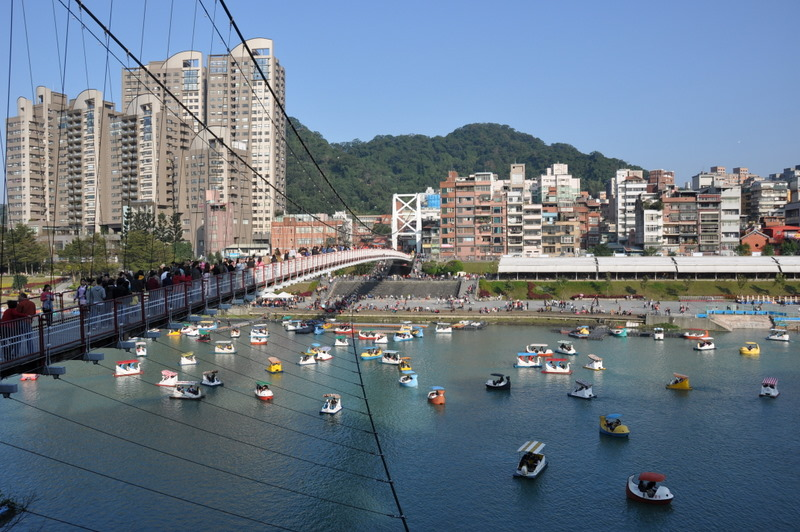

In this project, we take a look at a Taiwanese real estate valuation dataset. The market historical data set of real estate valuation are collected from Sindian Dist., New Taipei City, Taiwan. This dataset was sourced from the UCI machine learning repository. 

As for background information, according to Wikitravels:
"Xindian (新店), also known by its historical spelling Hsintien and alternative spelling Sindian, is a district located to the south of Taipei where the apartment complexes of the Taipei metropolitan area meet the northern end of the Central Mountain Range."

"Built later than many of the county's other municipalities, Xindian is a spacious suburb with good recreational facilities. Besides the famous Bitan Lake, the city also boasts good hiking areas in the mountains that surround the city. In recent years, IT industries have also expanded rapidily in Xindian, and this has greatly increased the affluence of the area. There are three large shopping complexes in Xindian, as well as a bustling downtown. The Hwa-yuan Xin-cheng (New Garden City) area of Xindian was developed in the 70s and 80s with the aim of attracting artists and writers. Thirty years later, the green hills, quiet environment and relatively inexpensive real estate prices of Garden City still attracts the art crowd, and in addition, many Westerners have settled there. New Garden City is located about twenty minutes from downtown Xindian, off the road to Wulai."



The dataset has 7 columns and a total of 414 rows. Below are details regarding the attributes. Out of the 7 columns, Y (house price of area unit) is the target variable

The purpose of this project is to explore the dataset in order to gain insights into the Taiwanese real estate market. We will also be able to see what factors into the valuation of housing. Such understanding could potentially lead to selection of a suitable machine learning model to predict other housing prices. 

Our initial hypothesis is that:


*   The closer a house to the station, the higher the value 
*   The older the house, the less value it has
*   Over the years, the general price of real estate increases

There might also be other nuances regarding the location of the house depending the geography of the district. It would make sense that being in the center of the district is more desirable than being on the outskirts for example.




##Features

Column   | Description                        | Unit                     
---------|------------------------------------|--------------------------
X1       | transaction date                   | year (decimals for month)
X2       | house age                          | year
X3       | distance to the nearest MRT station| meter
X4       | number of convenience stores       | whole number (integer)
X5       | Latitude                       | degree
X6       | Longitude                      | degree
Y        | House price of Area Unit           | 10000NTD/Ping where 1 ping = 3.3m^2


# Import Libraries and Dataset Summary

In [139]:
#library and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import os
%matplotlib inline

## Read data into pandas dataframe

In [140]:
#read directly from url
real_estate=pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx")

In [141]:
#store data as dataframe
Real_estate=pd.DataFrame(real_estate)

## Functions for use

Certain functions are defined in a class here for later use

In [142]:
class EDAfunctions:
  #one function to drop both rows with duplicate or null values from dataframe
  def drop_na_dup_rows(data):
    data.drop_na(axis=0, inplace=True)
    data.drop_duplicates(inplace=True)
  #box plots:
  def box_plt(data):
    plt.figure(figsize=(25,20))
    x = 1
    for y in list(data.columns)[1:]:
      plt.subplot(4,4,x)
      plt.boxplot(data[y])
      plt.title(y)
      x +=1
    plt.show()
  #histogram
  def hist_plt(data):
    plt.figure(figsize=(25,20))
    x = 1
    for y in list(data.columns)[1:]:
      plt.subplot(4,4,x)
      sns.distplot(data[y])
      plt.title(y)
      x+=1
    plt.show()
  #heatmap plotting
  def heat_plt(data):
    plt.figure(figsize = (22,11))
    corr = data.corr()
    sns.heatmap(corr, annot=True )
    plt.show()
  #check outliers in data
  def out_sum(data=Real_estate):
    results=pd.DataFrame(columns=['Column', 'Sum', 'Percentage'])
    for column in list(data.columns):
      #calculate quantile
      Q1, Q3 = np.percentile(data[column], [75, 25])
      iqr = Q1 - Q3
      max = Q1 + (iqr*1.5)
      min = Q3 - (iqr*1.5)
      #stats
      sum = len(np.where((data[column] > max) | 
                        (data[column] < min))[0])
      percent = round(sum/len(data[column])*100, 2)

      #show result as dataframe
      col_results = pd.DataFrame([[column, sum, percent]],
               columns = ['Column', 'Sum', 'Percentage'])
      results=results.append(col_results, ignore_index=True)
    results.sort_values("Percentage", ascending=False)
    return results

## Dataset overview

The dataset we found to be already in good shape with no null values or duplicated entries. Thus there isn't a need for rows to be dropped at this point

In [143]:
Real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


In [169]:
Real_estate.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [145]:
Real_estate.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


Taking a look at the table above, we can see for X2,X3,X4 and X5. The max values for those 2 columns seem clearly higher than the rest of the which might indicate outliers for those columns. However, being 6km away from a station and having 10 convenience stores around the area isn't a farfetched thing (so is having a 40year old building). We might not need to deal with outliers

In [146]:
#check total number of null rows
Real_estate.isnull().sum()

No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

In [147]:
#check for duplicated rows
Real_estate.duplicated().sum()

0

In [148]:
#drop no column, irrelevant to the dataframe
Real_estate.drop('No', axis=1, inplace=True)
Real_estate.shape

(414, 7)

The dataset excel file comes with a No column for index. It is redundant when imported into pandas dataframe thus will be dropped

# Exploring Data Visually

## Distribution

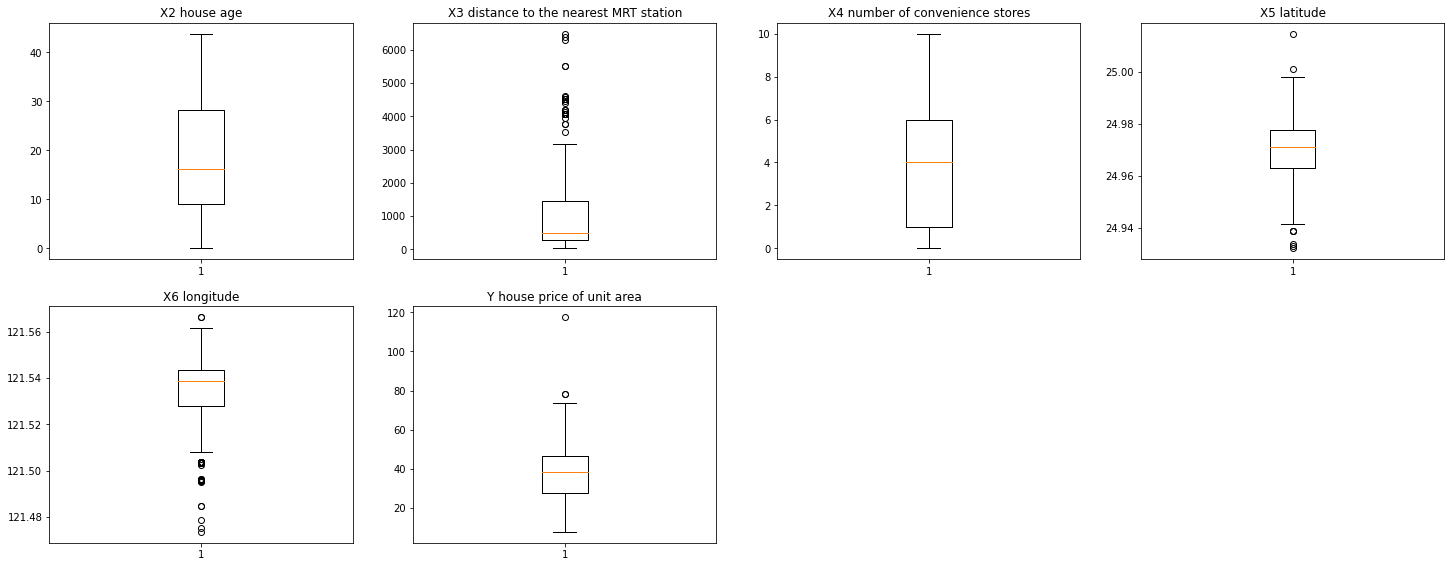

In [149]:
EDAfunctions.box_plt(Real_estate)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

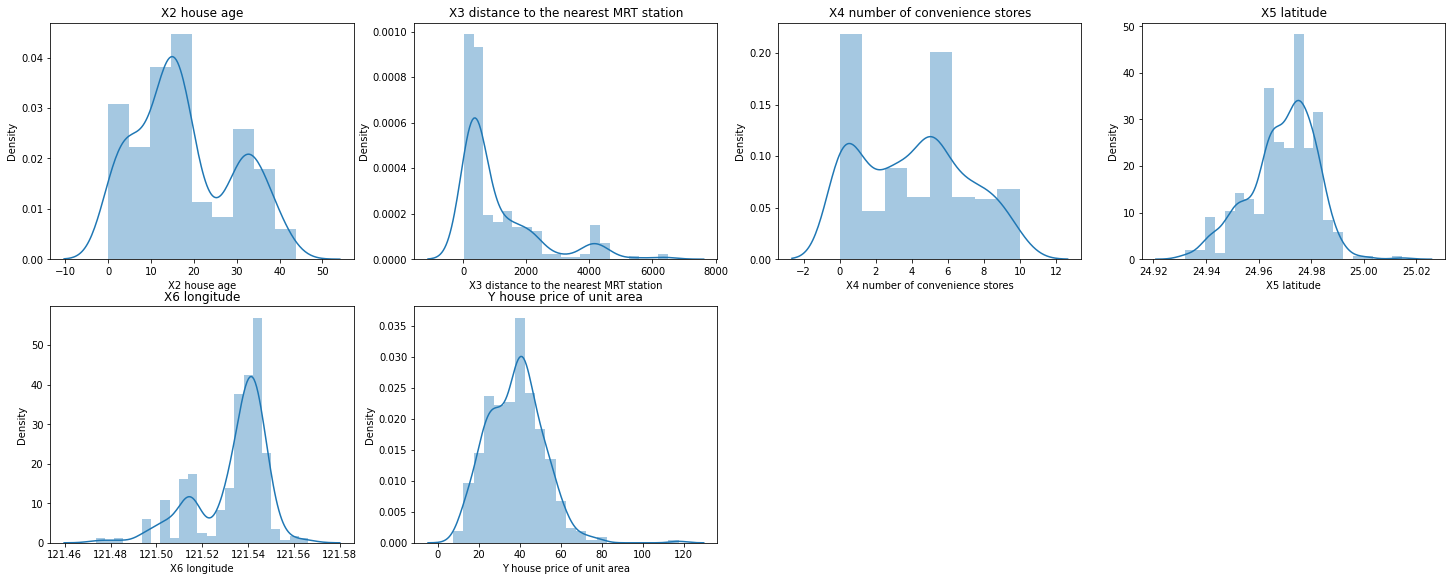

In [150]:
EDAfunctions.hist_plt(Real_estate)

Notice that:
* house ages tend to be either quite old (30 to about 43) or on the newer end with peaks being at very new building (0) or between 10 to 20 years old
* most houses are close to MRT stations
* even though there are quite a few that don't have convenience stores around, houses where there are stores around seem to occupy most of the dataset
* housing price can vary quite a bit between sub-20 to somewhere between 60 and 80 with a majority around the 30 to 50 area

In [151]:
display(EDAfunctions.out_sum())

,Column,Sum,Percentage
0,X1 transaction date,0,0.00
1,X2 house age,0,0.00
2,X3 distance to the nearest MRT station,37,8.94
3,X4 number of convenience stores,0,0.00
4,X5 latitude,8,1.93
5,X6 longitude,35,8.45
6,Y house price of unit area,3,0.72


The data's outliers are relatively neglibile so I think it is best to just leave the outliers alone. Furthermore, distance to the station as a variable makes sense in the context of the dataset as we have explained earlier when taking a look at the data numerically.

The box plots also suggest outliers in other columns as well. However taking a look 

## Correlation

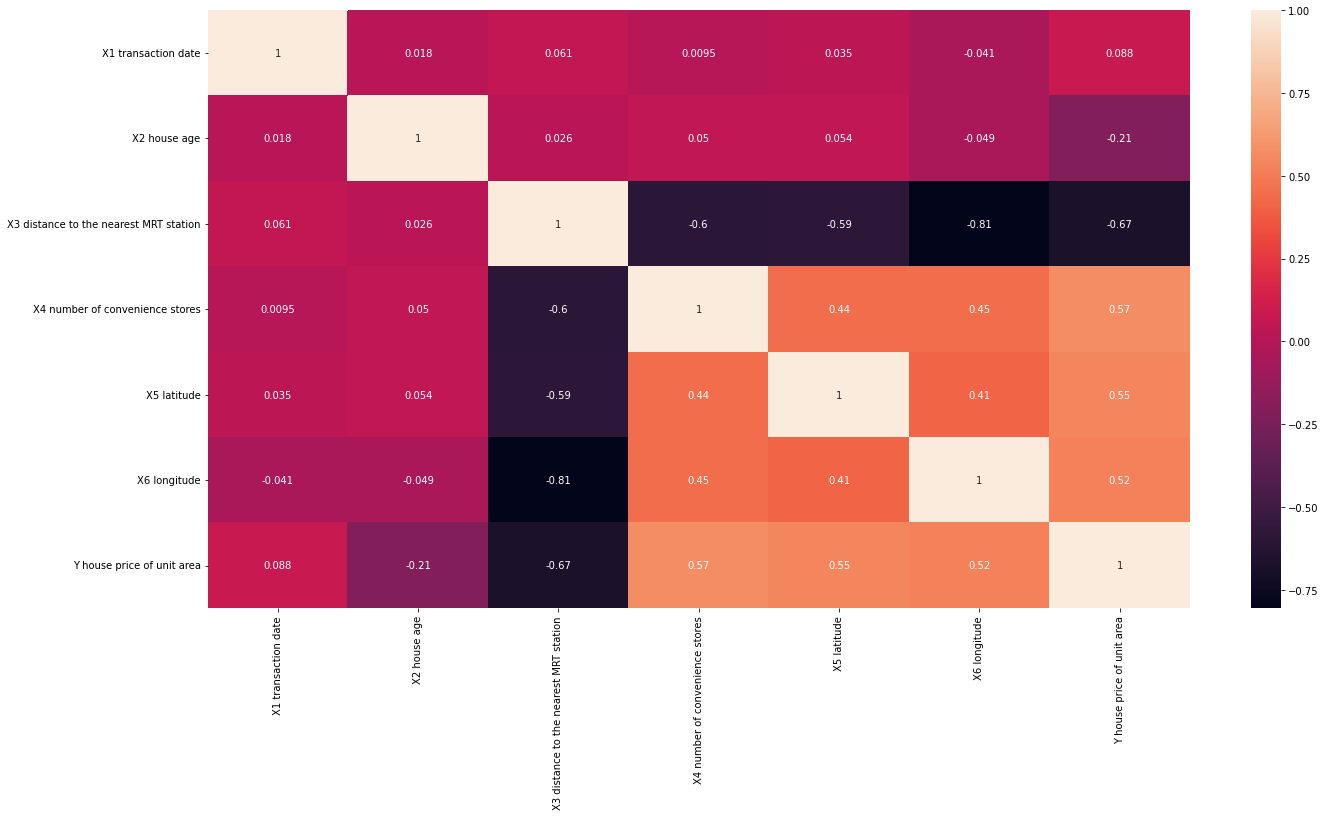

In [152]:
EDAfunctions.heat_plt(Real_estate)

<Figure size 1800x1080 with 0 Axes>

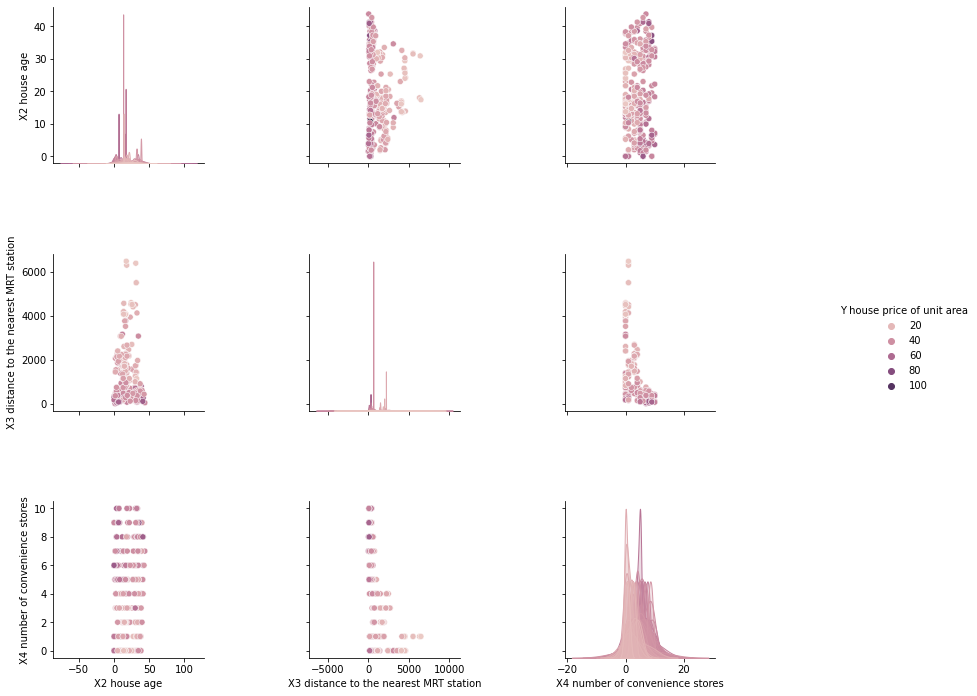

In [153]:
plt.figure(figsize =(25,15))
f = sns.pairplot(data=Real_estate, hue='Y house price of unit area', vars=['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores'])
f.fig.set_size_inches(14,10)
plt.show()

### Correlation between location and value

Here we examine location further

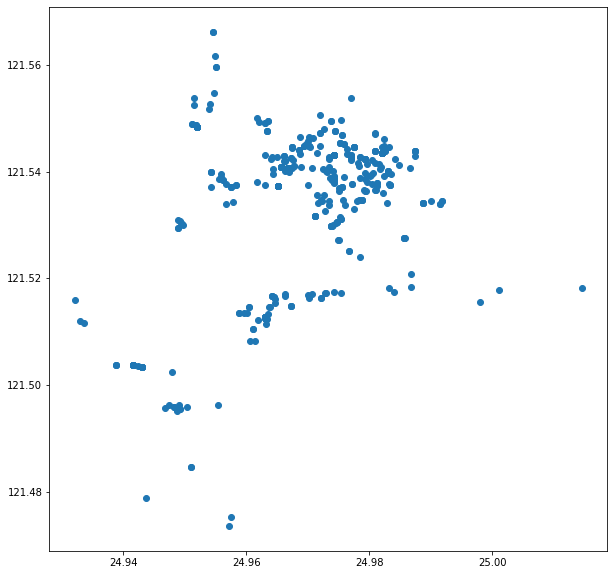

In [159]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(Real_estate['X5 latitude'], Real_estate['X6 longitude'])
plt.show()

Based on this scatter plot distribution, I assume the cluster of the points is where the center of the district is

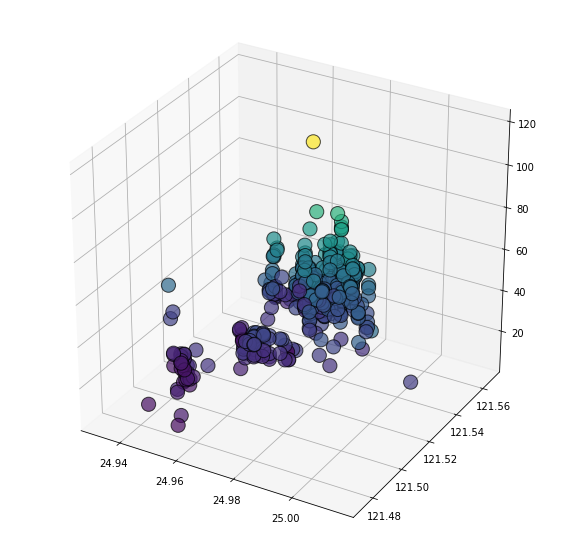

In [158]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Real_estate['X5 latitude'], Real_estate['X6 longitude'], Real_estate['Y house price of unit area'],
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=Real_estate['Y house price of unit area'])
plt.show()

The 3d plot for 3 variables show that the assumed center of the districts where most of these points gather have generally higher value than those further away, suggesting that housing in the cetner of the district is more valuable than those further away

### Line plots for better trend visualization

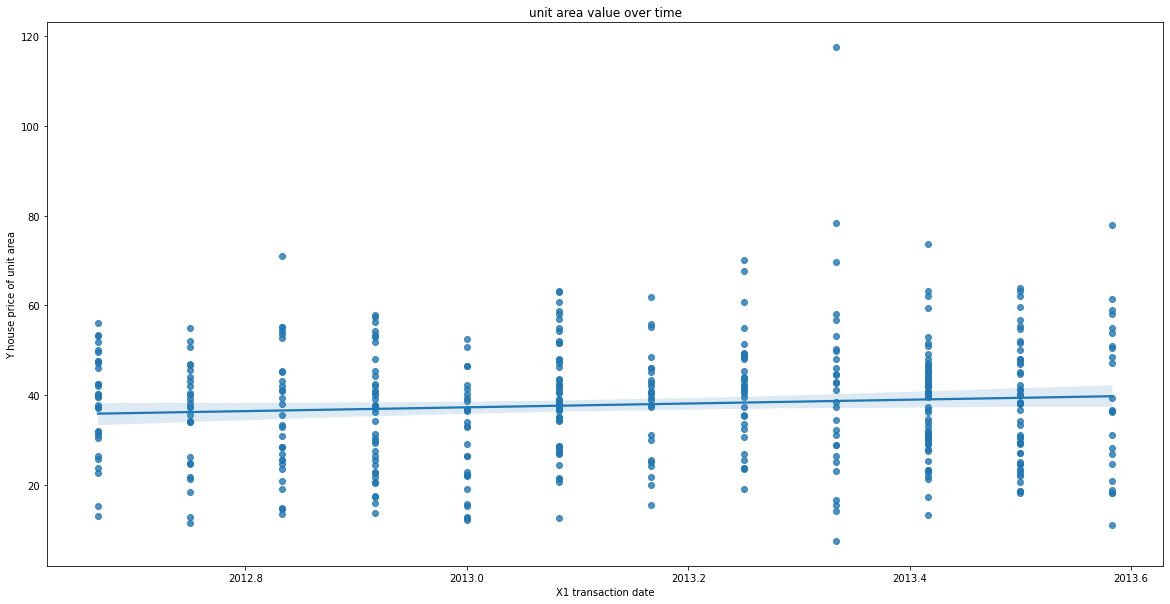

In [154]:
#examining trend
Real_estate_sorted = Real_estate.sort_values(by=['X1 transaction date'])
plt.figure(figsize =(20,10))
sns.regplot(x='X1 transaction date',y = 'Y house price of unit area', data=Real_estate_sorted)
plt.title('unit area value over time')
plt.show()

The increasing trend of price over the year is very neglible 

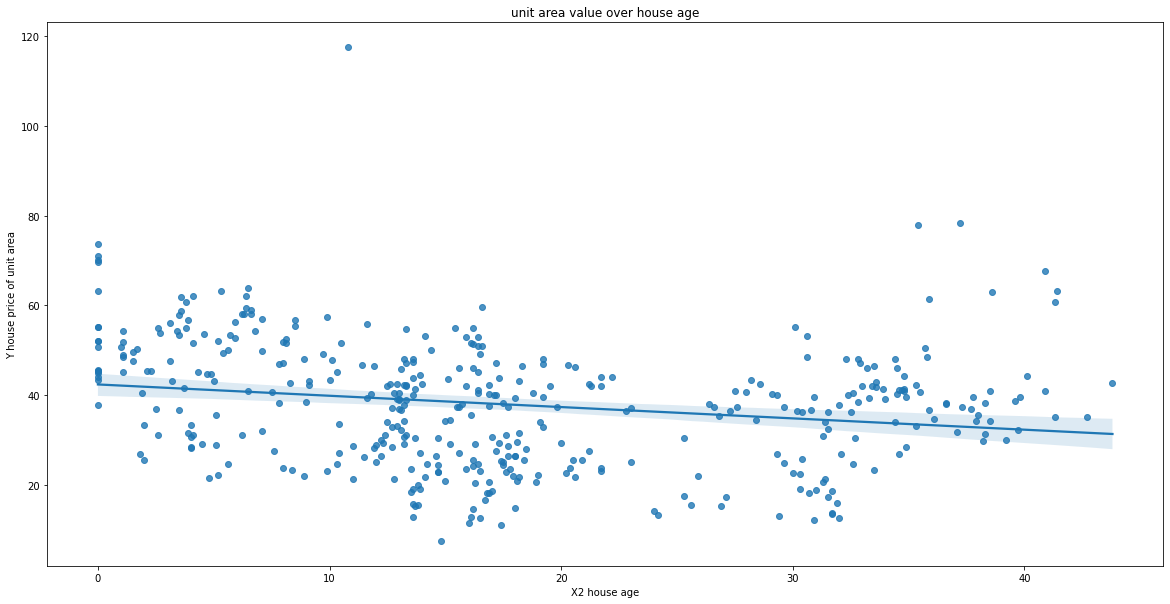

In [155]:
plt.figure(figsize =(20,10))
sns.regplot(x='X2 house age',y = 'Y house price of unit area', data=Real_estate_sorted)
plt.title('unit area value over house age')
plt.show()

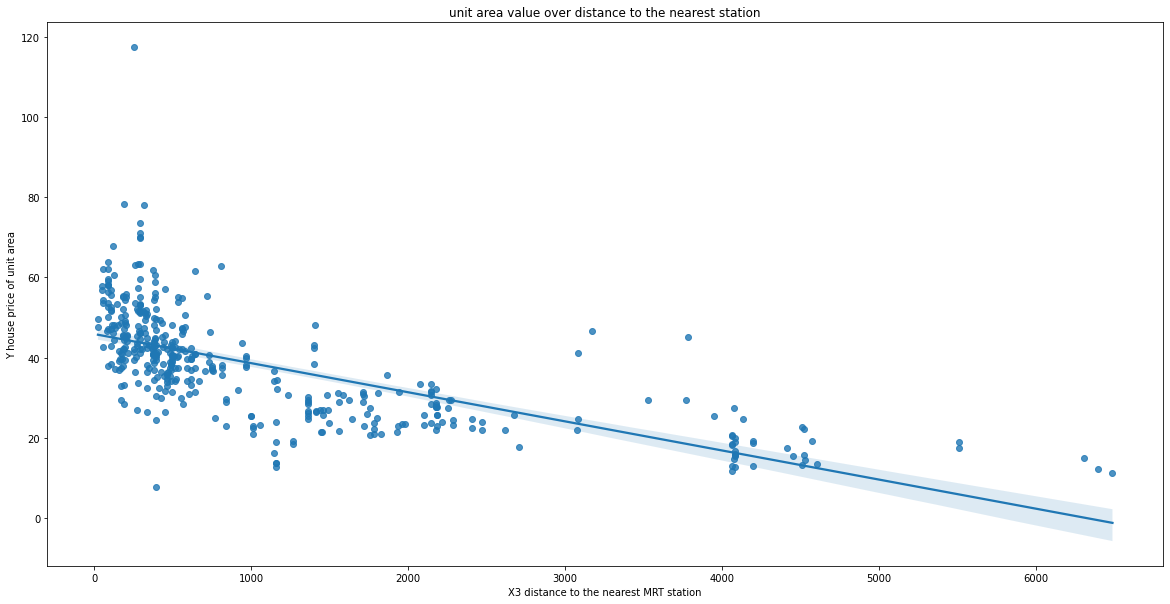

In [156]:
plt.figure(figsize =(20,10))
sns.regplot(x='X3 distance to the nearest MRT station',y = 'Y house price of unit area', data=Real_estate_sorted)
plt.title('unit area value over distance to the nearest station')
plt.show()

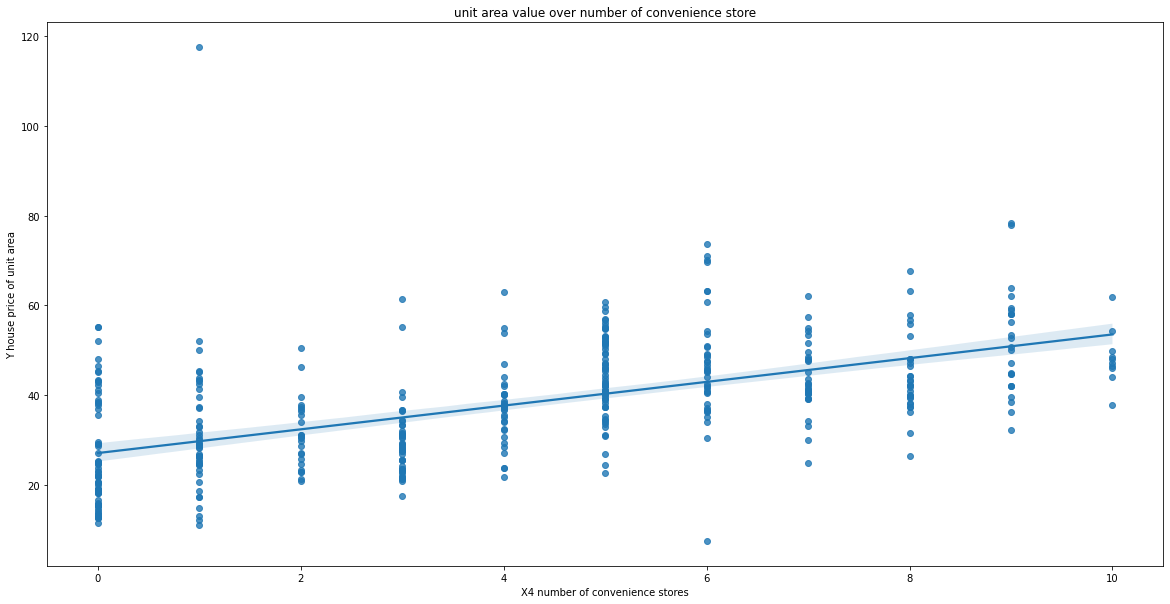

In [157]:
plt.figure(figsize =(20,10))
sns.regplot(x='X4 number of convenience stores',y = 'Y house price of unit area', data=Real_estate_sorted)
plt.title('unit area value over number of convenience store')
plt.show()

The heatmap and scatter plots shows that:
- surprisingly transaction date doesn't have much correlation
- house age has weak correlation in relation to house value
- distance (and also inversely for X,Y coordinates) has moderate negative correlation to house value
- number of convenience stores has moderate correlation to house value


# Conclusion

This confirms part of our initial hypothesis regarding Taiwanese real estate valuation. However it is surprising that the value of houses don't increase as much over the years, it maybe also very dependent on the age and location of the house.

In addition, based on the data distribution, it might suggest that Xindiang district seems to be in the process of further development. 